In [ ]:
import pandas as pd
import numpy as np
import pickle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats

def find_dense_periods(df, stage_value, window_size=3600):
    stage_binary = (df['sleepStage'] == stage_value).astype(int)
    stage_density = []
    
    for i in range(len(df) - window_size + 1):
        density = np.mean(stage_binary[i:i + window_size])
        stage_density.append(density)
    
    peaks, _ = find_peaks(stage_density, height=0.66, distance=1200)
    return [df['Timestamp'].iloc[peak] for peak in peaks]

def get_prior_period_stats(period_starts, sleep_df, exp_df):
    stats = []
    for start in period_starts:
        window_start = start - timedelta(hours=2)
        
        # Get proportion of NREM in prior window
        mask_sleep = (sleep_df['Timestamp'] >= window_start) & (sleep_df['Timestamp'] < start)
        prior_window = sleep_df.loc[mask_sleep]
        nrem_prop = (prior_window['sleepStage'] == 2).mean()
        
        # Get mean exponent
        mask_exp = (exp_df['Timestamp'] >= window_start) & (exp_df['Timestamp'] < start)
        mean_exp = exp_df.loc[mask_exp, 'exponent'].mean()
        
        stats.append({'proportion_nrem': nrem_prop, 'mean_exponent': mean_exp})
    return stats

def process_single_subject(csv_path, pickle_path):
    # Load data
    sleep_df = pd.read_csv(csv_path)
    sleep_df['Timestamp'] = pd.to_datetime(sleep_df['Timestamp'])
    
    with open(pickle_path, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2
    
    exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0], 
                             periods=len(avg_exps), 
                             freq='10S')
    exp_df = pd.DataFrame({'Timestamp': exp_times, 'exponent': avg_exps})
    
    # Get dense NREM periods and their stats
    nrem_periods = find_dense_periods(sleep_df, stage_value=2)
    nrem_stats = get_prior_period_stats(nrem_periods, sleep_df, exp_df)
    
    return nrem_stats

def process_all_subjects(csv_files, pickle_files):
    data_list = []
    
    for subject_id, (csv_file, pickle_file) in enumerate(zip(csv_files, pickle_files), 1):
        nrem_stats = process_single_subject(csv_file, pickle_file)
        
        for stats in nrem_stats:
            data_list.append({
                'Subject': f'sub-{subject_id:03d}',
                'Proportion_NREM': stats['proportion_nrem'],
                'Exponent': stats['mean_exponent']
            })
    
    return pd.DataFrame(data_list)

def plot_nrem_proportion_vs_exponent(csv_files, pickle_files, output_file):
    # Process data
    df = process_all_subjects(csv_files, pickle_files)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    
    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Proportion_NREM'], 
                                                                   df['Exponent'])
    
    # Plot individual points
    sns.scatterplot(data=df, x='Proportion_NREM', y='Exponent', alpha=0.6)
    
    # Add regression line
    sns.regplot(data=df, x='Proportion_NREM', y='Exponent', 
                scatter=False, color='red', line_kws={'linestyle': '--'})
    
    # Add stats text
    stats_text = (f'r = {r_value:.3f}\n'
                  f'p = {p_value:.2e}\n'
                  f'y = {slope:.2e}x + {intercept:.2e}')
    plt.text(0.05, 0.95, stats_text,
             transform=plt.gca().transAxes, 
             fontsize=12,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xlabel('Proportion of NREM in Prior 2 Hours', fontsize=14)
    plt.ylabel('1/f Exponent', fontsize=14)
    plt.title('NREM Proportion vs 1/f Exponent\nin Prior 2-hour Period', fontsize=16)
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    #plt.savefig(output_file, dpi=600)
    plt.show()

# File paths
csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]

# Call the new plotting function
plot_nrem_proportion_vs_exponent(csv_files, pickle_files, 
    '/Volumes/harris/volkan/fooof/plots/prior_period/nrem_proportion_vs_exponent.png')

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_12591/1357357749.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],


KeyError: 'proportion_nrem'

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_13613/3580033988.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_13613/3580033988.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_13613/3580033988.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_13613/3580033988.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/

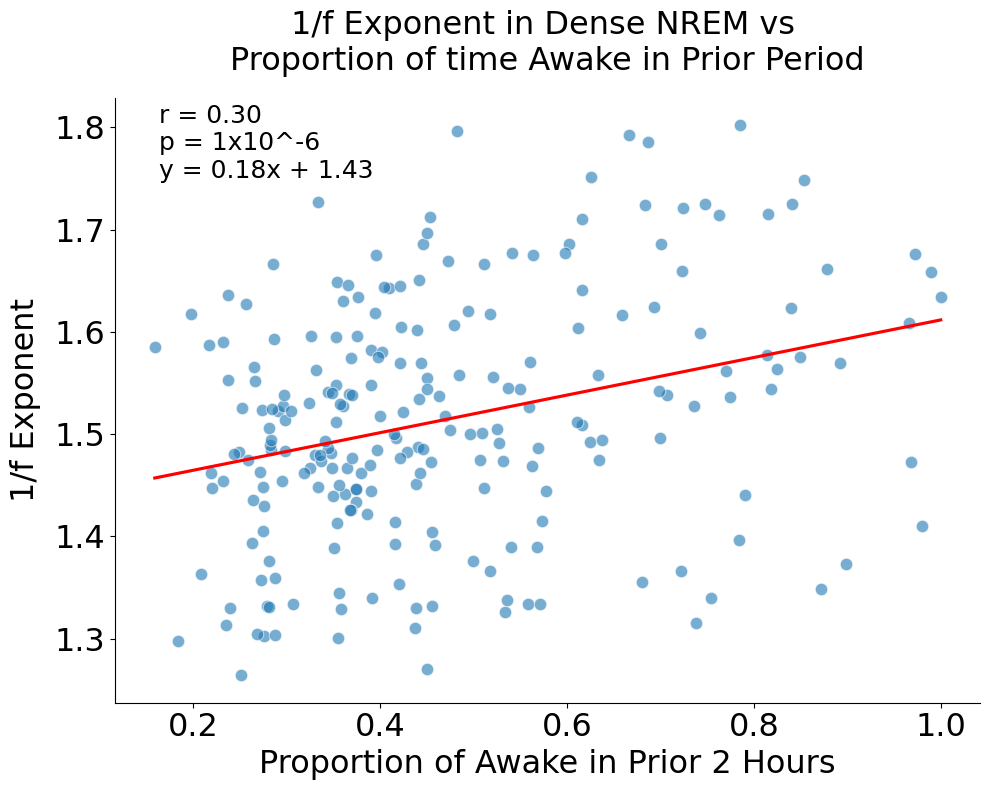

In [12]:
import pandas as pd
import numpy as np
import pickle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats

def find_dense_periods(df, stage_value, window_size=3600):
    stage_binary = (df['sleepStage'] == stage_value).astype(int)
    stage_density = []
    
    for i in range(len(df) - window_size + 1):
        density = np.mean(stage_binary[i:i + window_size])
        stage_density.append(density)
    
    peaks, _ = find_peaks(stage_density, height=0.66, distance=1200)
    return [df['Timestamp'].iloc[peak] for peak in peaks]

def get_period_stats(period_starts, sleep_df, exp_df):
    stats = []
    for start in period_starts:
        window_start = start - timedelta(hours=2)
        window_end = start + timedelta(hours=1)  # 1-hour dense NREM period
        
        # Get proportion of Awake in prior window
        mask_prior = (sleep_df['Timestamp'] >= window_start) & (sleep_df['Timestamp'] < start)
        prior_window = sleep_df.loc[mask_prior]
        awake_prop = (prior_window['sleepStage'] == 1).mean()
        
        # Get mean exponent during dense NREM period
        mask_nrem = (exp_df['Timestamp'] >= start) & (exp_df['Timestamp'] < window_end)
        mean_exp = exp_df.loc[mask_nrem, 'exponent'].mean()
        
        stats.append({'proportion_awake': awake_prop, 'mean_exponent': mean_exp})
    return stats

def process_single_subject(csv_path, pickle_path):
    # Load data
    sleep_df = pd.read_csv(csv_path)
    sleep_df['Timestamp'] = pd.to_datetime(sleep_df['Timestamp'])
    
    with open(pickle_path, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2
    
    exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0], 
                             periods=len(avg_exps), 
                             freq='10S')
    exp_df = pd.DataFrame({'Timestamp': exp_times, 'exponent': avg_exps})
    
    # Get dense NREM periods and their stats
    nrem_periods = find_dense_periods(sleep_df, stage_value=2)
    nrem_stats = get_period_stats(nrem_periods, sleep_df, exp_df)
    
    return nrem_stats

def process_all_subjects(csv_files, pickle_files):
    data_list = []
    
    for subject_id, (csv_file, pickle_file) in enumerate(zip(csv_files, pickle_files), 1):
        nrem_stats = process_single_subject(csv_file, pickle_file)
        
        for stats in nrem_stats:
            data_list.append({
                'Subject': f'sub-{subject_id:03d}',
                'Proportion_Awake': stats['proportion_awake'],  # Changed from NREM
                'Exponent': stats['mean_exponent']
            })
    
    return pd.DataFrame(data_list)

def plot_awake_proportion_vs_exponent(csv_files, pickle_files, output_file):
    df = process_all_subjects(csv_files, pickle_files)
    
    plt.figure(figsize=(10, 8))
    
    # Calculate regression and plot
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Proportion_Awake'], 
                                                                   df['Exponent'])
    
    sns.scatterplot(data=df, x='Proportion_Awake', y='Exponent', alpha=0.6, s=80)
    sns.regplot(data=df, x='Proportion_Awake', y='Exponent', 
                scatter=False, color='red', line_kws={'linestyle': '-'}, ci=None)
    
    # Calculate p-value in scientific notation base 10
    p_val_exp = int(np.floor(np.log10(p_value)))
    
    # Add stats text
    stats_text = (f'r = {r_value:.2f}\n'
                  f'p = 1x10^{p_val_exp}\n'
                  f'y = {slope:.2f}x + {intercept:.2f}')
    plt.text(0.05, 0.99, stats_text,
             transform=plt.gca().transAxes, 
             fontsize=18,
             verticalalignment='top')
    
    plt.xlabel('Proportion of Awake in Prior 2 Hours', fontsize=23)
    plt.ylabel('1/f Exponent', fontsize=23, labelpad=10)
    plt.title('1/f Exponent in Dense NREM vs \nProportion of time Awake in Prior Period', fontsize=23, pad=20)
    plt.tick_params(axis='both', labelsize=23)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    #plt.savefig(output_file, dpi=600)
    plt.show()

# File paths
csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]

# Call the new plotting function
plot_awake_proportion_vs_exponent(csv_files, pickle_files, 
    '/Volumes/harris/volkan/fooof/plots/prior_period/nrem_proportion_vs_exponent.png')

/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_15472/1187252918.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_15472/1187252918.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_15472/1187252918.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/1pj77pp55jgbyxgsst2fw9rr0000gn/T/ipykernel_15472/1187252918.py:52: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0],
/var/folders/sy/

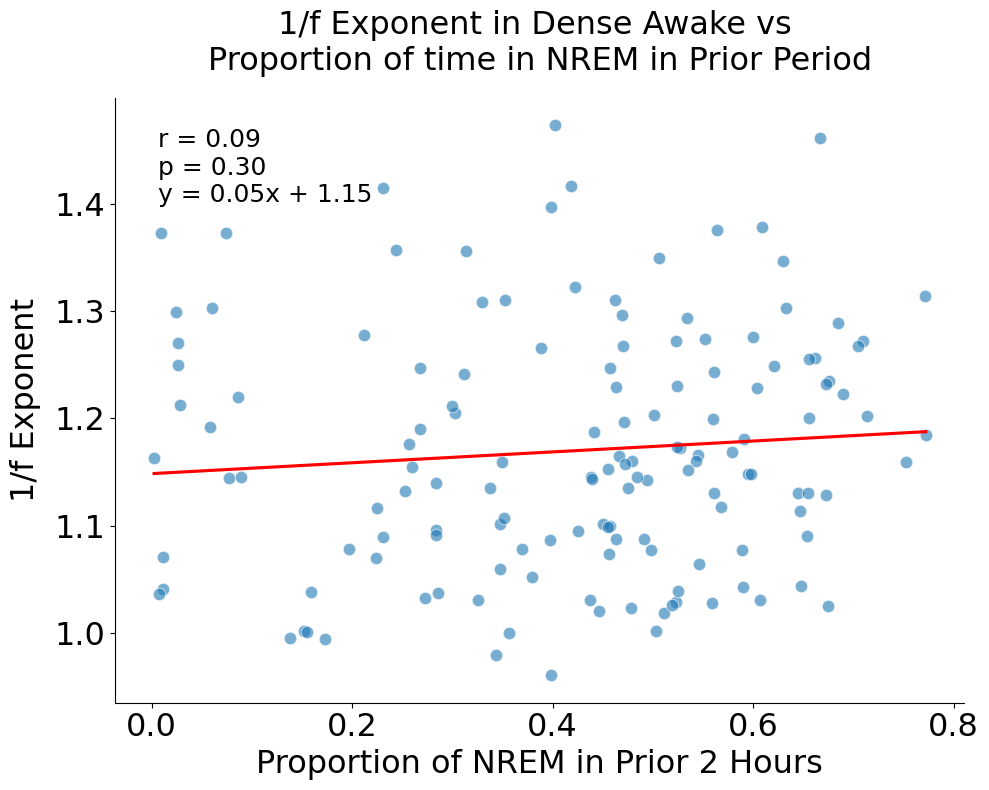

In [4]:
import pandas as pd
import numpy as np
import pickle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats

def find_dense_periods(df, stage_value, window_size=3600):
    stage_binary = (df['sleepStage'] == stage_value).astype(int)
    stage_density = []
    
    for i in range(len(df) - window_size + 1):
        density = np.mean(stage_binary[i:i + window_size])
        stage_density.append(density)
    
    peaks, _ = find_peaks(stage_density, height=0.66, distance=1200)
    return [df['Timestamp'].iloc[peak] for peak in peaks]

def get_period_stats_awake(period_starts, sleep_df, exp_df):
    stats = []
    for start in period_starts:
        window_start = start - timedelta(hours=2)
        window_end = start + timedelta(hours=1)  # 1-hour dense Awake period
        
        # Get proportion of NREM in prior window
        mask_prior = (sleep_df['Timestamp'] >= window_start) & (sleep_df['Timestamp'] < start)
        prior_window = sleep_df.loc[mask_prior]
        nrem_prop = (prior_window['sleepStage'] == 2).mean()  # Changed to NREM (state 2)
        
        # Get mean exponent during dense Awake period
        mask_awake = (exp_df['Timestamp'] >= start) & (exp_df['Timestamp'] < window_end)
        mean_exp = exp_df.loc[mask_awake, 'exponent'].mean()
        
        stats.append({'proportion_nrem': nrem_prop, 'mean_exponent': mean_exp})
    return stats

def process_single_subject_awake(csv_path, pickle_path):
    # Load data
    sleep_df = pd.read_csv(csv_path)
    sleep_df['Timestamp'] = pd.to_datetime(sleep_df['Timestamp'])
    
    with open(pickle_path, 'rb') as f:
        fg_models = pickle.load(f)
    
    # Calculate average exponents
    exps_eeg1 = fg_models['EEG1'].get_params('aperiodic_params', 'exponent')
    exps_eeg2 = fg_models['EEG2'].get_params('aperiodic_params', 'exponent')
    avg_exps = (exps_eeg1 + exps_eeg2) / 2
    
    exp_times = pd.date_range(start=sleep_df['Timestamp'].iloc[0], 
                             periods=len(avg_exps), 
                             freq='10S')
    exp_df = pd.DataFrame({'Timestamp': exp_times, 'exponent': avg_exps})
    
    awake_periods = find_dense_periods(sleep_df, stage_value=1)
    awake_stats = get_period_stats_awake(awake_periods, sleep_df, exp_df)
    
    return awake_stats

def process_all_subjects(csv_files, pickle_files):
    data_list = []
    
    for subject_id, (csv_file, pickle_file) in enumerate(zip(csv_files, pickle_files), 1):
        awake_stats = process_single_subject_awake(csv_file, pickle_file)
        
        for stats in awake_stats:
            data_list.append({
                'Subject': f'sub-{subject_id:03d}',
                'Proportion_NREM': stats['proportion_nrem'],  # Changed from NREM
                'Exponent': stats['mean_exponent']
            })
    
    return pd.DataFrame(data_list)

def plot_prior_nrem_vs_awake_exponent(csv_files, pickle_files, output_file):
    df = process_all_subjects(csv_files, pickle_files)
    
    plt.figure(figsize=(10, 8))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Proportion_NREM'], 
                                                                   df['Exponent'])
    
    sns.scatterplot(data=df, x='Proportion_NREM', y='Exponent', alpha=0.6, s=80)
    sns.regplot(data=df, x='Proportion_NREM', y='Exponent', 
                scatter=False, color='red', line_kws={'linestyle': '-'}, ci=None)
    
    
    stats_text = (f'r = {r_value:.2f}\n'
                  f'p = {p_value:.2f}\n'
                  f'y = {slope:.2f}x + {intercept:.2f}')
    plt.text(0.05, 0.99, stats_text,
             transform=plt.gca().transAxes, 
             fontsize=18,
             verticalalignment='top')
    
    plt.xlabel('Proportion of NREM in Prior 2 Hours', fontsize=23)
    plt.ylabel('1/f Exponent', fontsize=23, labelpad=10)
    plt.title('1/f Exponent in Dense Awake vs \nProportion of time in NREM in Prior Period', 
              fontsize=23, pad=20)
    plt.tick_params(axis='both', labelsize=23)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    #plt.savefig(output_file, dpi=600)
    plt.show()

# File paths
csv_files = [
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-007_ses-01_recording-01_time-0-70.5h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-010_ses-01_recording-01_time-0-69h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-011_ses-01_recording-01_time-0-72h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-015_ses-01_recording-01_time-0-49h_1Hz_stitched.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-016_ses-02_recording-01_time-0-91h_1Hz.csv',
    '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/scoring_analysis/automated_state_annotationoutput_sub-017_ses-01_recording-01_time-0-98h_1Hz.csv'
]

pickle_files = [
    '/Volumes/harris/volkan/fooof/fooof_results/sub-007_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-010_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-011_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-015_ses-01_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-016_ses-02_recording-01_fooof.pkl',
    '/Volumes/harris/volkan/fooof/fooof_results/sub-017_ses-01_recording-01_fooof.pkl'
]

# Call the new plotting function
plot_prior_nrem_vs_awake_exponent(csv_files, pickle_files, 
    '/Volumes/harris/volkan/fooof/plots/prior_period/nrem_proportion_vs_exponent.png')